# 📸 Bulk Labeling Multimodal Data


In this tutorial, we will work with multimodal data of images and text. It will walk you through the following steps:

- Load a dataset with images and text of electronic products.
- Experiment with zero-shot image and text classification.
- Label the data using bulk labelling with image and text embeddings.
- Train a SetFit classification model on the labelled data.

<img src="../../_static/tutorials/labelling-textclassification-sentencetransformers-semantic/argilla_image_cables.png" alt="Argilla with images tutorial" style="width: 1100px;">


## Running Argilla

For this tutorial, you will need to have an Argilla server running. There are two main options for deploying and running Argilla:

1. [Deploy Argilla on Hugging Face Spaces](https://huggingface.co/docs/hub/spaces-sdks-docker-argilla): This is the fastest option and the recommended choice for connecting to external notebooks (e.g., Google Colab) if you have an account on Hugging Face.

2. [Launch Argilla using Argilla's quickstart Docker image](../../getting_started/quickstart.ipynb): This is the recommended option if you want Argilla running on your local machine. Note that this option will only let you run the tutorial locally and not with an external notebook service.

For more information on deployment options, please check the Deployment section of the documentation.

<div class="alert alert-info">

Tip
    
This tutorial is a Jupyter Notebook. There are two options to run it:

- Use the Open in Colab button at the top of this page. This option allows you to run the notebook directly on Google Colab. Don't forget to change the runtime type to GPU for faster model training and inference.
- Download the .ipynb file by clicking on the View source link at the top of the page. This option allows you to download the notebook and run it on your local machine or on a Jupyter notebook tool of your choice.
</div>

## Setup

For this tutorial, you'll need to install the Argilla client and a few third-party libraries using `pip`:

## Introduction

__Real-world multimodal data__ is often a mix of text and images. In this tutorial, we will work with a dataset of electronic products. The dataset contains images of the products and a description of the product. 

This notebook uses a dataset of electronics parts and products from a fictional electronics webshop. 

Let's get started!

In [2]:
%pip install argilla "setfit~=0.2.0" "datasets~=2.3.0" transformers sentence-transformers -qqq

Let's import the Argilla module for reading and writing data:

In [1]:
import argilla as rg

If you are running Argilla using the Docker quickstart image or Hugging Face Spaces, you need to init the Argilla client with the `URL` and `API_KEY`:

In [ ]:
# Replace api_url with the url to your HF Spaces URL if using Spaces
# Replace api_key if you configured a custom API key
rg.init(api_url="https://localhost:6900", api_key="admin.apikey")

If you're running a private Hugging Face Space, you will also need to set the [HF_TOKEN](https://huggingface.co/settings/tokens) as follows:

In [ ]:
# # Set the HF_TOKEN environment variable
# import os
# os.environ['HF_TOKEN'] = "your-hf-token"

# # Replace api_url with the url to your HF Spaces URL
# # Replace api_key if you configured a custom API key
# rg.init(
#     api_url="https://[your-owner-name]-[your_space_name].hf.space",
#     api_key="admin.apikey",
#     extra_headers={"Authorization": f"Bearer {os.environ['HF_TOKEN']}"},
# )

Finally, let's include the imports we need:

In [ ]:
import os
import pprint as pp
from requests import get

from datasets import load_dataset
from PIL import Image
from sklearn.metrics import accuracy_score
from sentence_transformers import SentenceTransformer
from transformers import pipeline
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer
from PIL import Image

### Enable Telemetry

We gain valuable insights from how you interact with our tutorials. To improve ourselves in offering you the most suitable content, using the following lines of code will help us understand that this tutorial is serving you effectively. Though this is entirely anonymous, you can choose to skip this step if you prefer. For more info, please check out the [Telemetry](../../reference/telemetry.md) page.

In [ ]:
try:
    from argilla.utils.telemetry import tutorial_running

    tutorial_running()
except ImportError:
    print(
        "Telemetry is introduced in Argilla 1.20.0 and not found in the current installation. Skipping telemetry."
    )

## A 'real-world' multimodal dataset

The dataset samples contain a `page_name`, `page_descriptions`, and a `label`. The dataset is split into two parts: `labelled` and `unlabelled`. The labelled portion is the result of my annotation so we can test methods. In reality, let's say this doesn't exist 😏. 

In [ ]:
ELECTRONICS_DATASET = "burtenshaw/electronics"
dataset = load_dataset(ELECTRONICS_DATASET)
labels = dataset["labelled"].features["label"].names
int2str = dataset["labelled"].features["label"].int2str

In [12]:
# show a sample
pp.pprint(next(iter(dataset["labelled"])))

{'image_url': 'https://tse1.mm.bing.net/th?id=OIP.to3Cddhws6ECl-_ySZ5ShQHaFi&pid=Api',
 'label': 1,
 'page_description': '\n'
                     '\n'
                     'Are you looking for a way to reduce the number of '
                     'purchase orders you need to place for cable assemblies? '
                     "If so, then this guide is for you! We'll show you how to "
                     'source cable assemblies with fewer purchase orders, '
                     "saving you time and money. We'll cover topics such as "
                     'understanding the different types of cable assemblies, '
                     'researching suppliers, and negotiating the best prices. '
                     "We'll also provide tips on how to streamline the "
                     'ordering process and ensure you get the best quality '
                     "products. With this guide, you'll be able to source "
                     'cable assemblies with fewer purchase orders and get 

## 🔫 Zero-Shot Classification

### 📷 Images

First, we will explore some zero-shot techniques. For the sake of comparison, we will use the `labelled` portion of the dataset.


In [ ]:
# to save time, we'll take a slice of the dataset
test_dataset = load_dataset(ELECTRONICS_DATASET, split="test[:20%]")

In [ ]:
# More models in the model hub.
model_name = "openai/clip-vit-large-patch14"
classifier = pipeline("zero-shot-image-classification", model=model_name)

First, we can zero-shot classify one image from the dataset: 

{'label': 'switches', 'score': 0.9631496667861938}


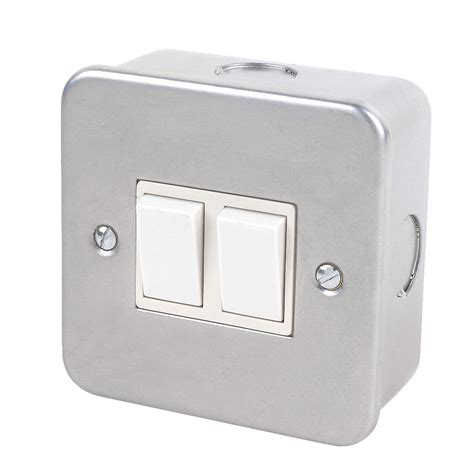

In [15]:
image_to_classify = next(iter(dataset["test"]))["image_url"]
scores = classifier(image_to_classify, candidate_labels=labels)
# show a sample
pp.pprint(scores[0])
Image.open(get(image_to_classify, stream=True).raw)

Now we will test the accuracy and latency of a zero-shot image classifier on a sub-section of the `labelled` portion of the dataset.

In [16]:
%%time


def classify_image(sample):
    label = classifier(sample["image_url"], candidate_labels=labels)[0]["label"]
    sample["clip_zero_shot"] = labels.index(label)
    return sample


test_dataset = test_dataset.map(classify_image)

CPU times: user 9min 20s, sys: 1.19 s, total: 9min 21s
Wall time: 2min 28s


In [17]:
zero_shot_image_accuracy = accuracy_score(
    test_dataset["label"], test_dataset["clip_zero_shot"]
)
print(f"Accuracy: {zero_shot_image_accuracy}")

Accuracy: 0.8235294117647058


😞 Zero-shot image classification with a CLIP model gives an accuracy of **0.82** in just under **2 minutes** for only **20%** of the test data. This score is not impressive. Let's see if the text is more reliable.

### 📚 Text
The product description and name also contain valuable information. Let's see what zero-shot classification of those can achieve. 

In [18]:
classifier = pipeline(model="facebook/bart-large-mnli")

In [19]:
%%time


def classify_text(sample):
    label = classifier(sample["page_description"], candidate_labels=labels)["labels"][0]
    sample["bart_zero_shot"] = labels.index(label)
    return sample


test_dataset = test_dataset.map(classify_text)

Accuracy: 0.8235294117647058
CPU times: user 5min 41s, sys: 1.29 s, total: 5min 42s
Wall time: 1min 33s


In [20]:
zero_shot_text_accuracy = accuracy_score(
    test_dataset["label"], test_dataset["clip_zero_shot"]
)
print(f"Accuracy: {zero_shot_text_accuracy}")

Accuracy: 0.8235294117647058


😞 Text classification takes less time, but accuracy is also less at __.79__. This shows that some information is held in images that are not in the text. It would be great if we could consolidate this information. 🤞

Furthermore, both of these approaches use large language models that consume a significant amount of computation.

## Consolidate data labeling

The scores above from two zero-shot classification approaches reveal that the task is possible but challenging using a zero-shot approach. 

With (our modified) Argilla, we can re-label the dataset and combine the information from image and text. Then, we can perform few-shot learning on the dataset.

Spoiler: this should give us a better score than the zero-shot approaches, by combining information in image and text. Furthermore, our resulting language model should have lower latency than the zero-shot models.

## Bulk Labeling with embeddings


### 📷 Images

Now we can use a clip model to get image embeddings for the images in the dataset. We can then repeat the process of adding vectors to our dataset, but now with an `image_vectors` key.

In [ ]:
# Load CLIP model for image embedding
image_encoder = SentenceTransformer("clip-ViT-B-32")

In [ ]:
def encode_image(image_url):
    # utility function to encode image
    image = Image.open(get(image_url, stream=True).raw)
    vector = image_encoder.encode(image).tolist()
    return vector


# Encode text field using batched computation
dataset = dataset.map(
    lambda sample: {"image_vectors": encode_image(sample["image_url"])}
)

### 📚 Text

With Argilla, we can annotate samples using semantic search and the 'find similar' button. There's a complete tutorial on this [here](labelling-textclassification-sentence-transformers-semantic.ipynb). It requires the recently added Similarity search features.

![Argilla with images tutorial](https://docs.v1.argilla.io/en/latest/_static/reference/webapp/features-similaritysearch.png)



In [33]:
# Define sentence transformers model for text embedding
dataset = load_dataset(ELECTRONICS_DATASET, streaming=True, split="unlabelled")
encoder = SentenceTransformer("all-MiniLM-L6-v2")

In [34]:
# Encode text field using batched computation
dataset = dataset.map(
    lambda batch: {"text_vectors": encoder.encode(batch["page_name"]).tolist()},
    batch_size=32,
    batched=True,
)

## Upload to Argilla

We can upload multiple vectors to Argilla. We just need to use separate keys. We will use `image_vectors` and `text_vectors`.

In [37]:
# Turn vectors into a dictionary
dataset = dataset.map(
    lambda r: {"vectors": {"image": r["image_vectors"], "text": r["text_vectors"]}},
)

In [ ]:
# we need to set the metadata field length to 200 for longer urls
os.environ["ARGILLA_METADATA_FIELD_LENGTH"] = "200"

# instantiate Argilla records with vectors
records = [
    rg.TextClassificationRecord(
        text=sample["page_name"],
        metadata=dict(_image_url=sample["image_url"]),
        vectors=sample["vectors"],
    )
    for sample in dataset
]
dataset_rg = rg.DatasetForTextClassification(records)

# upload recors with vectors to Argilla
rg.log(
    records=dataset_rg,
    name="electronics_with_vectors",
)

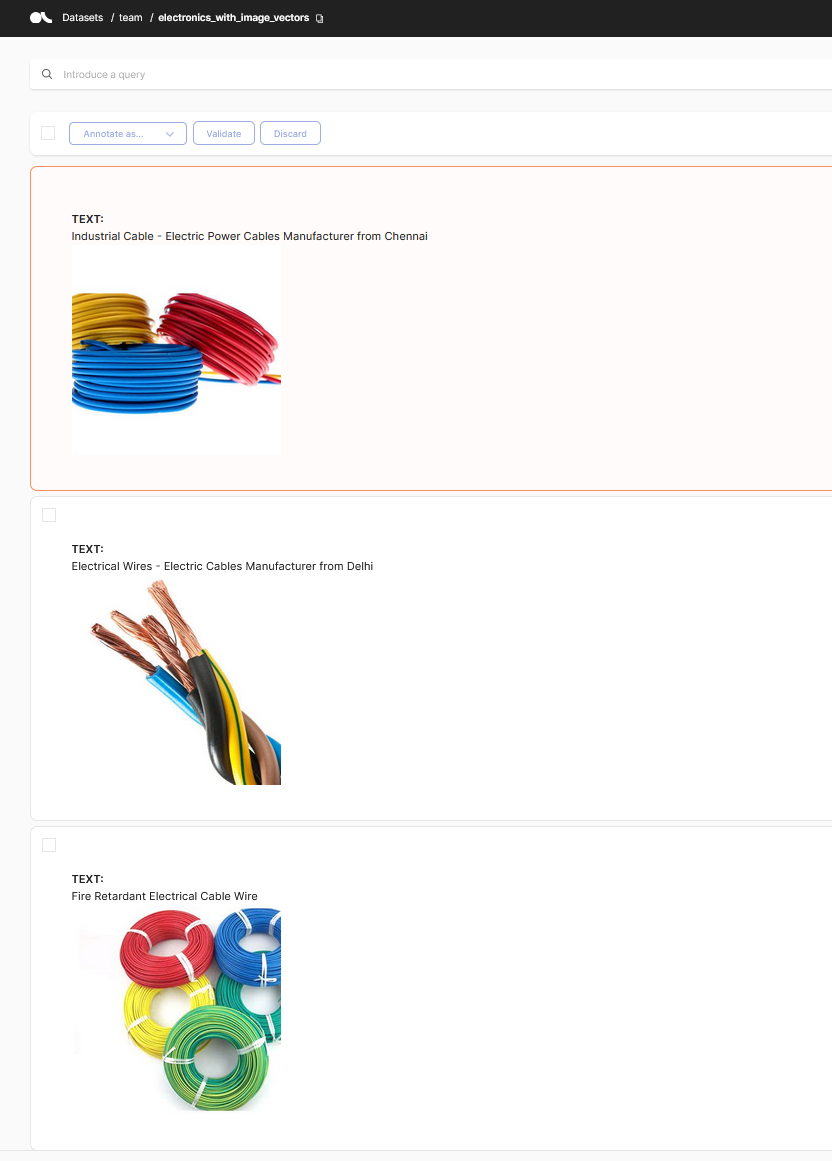

## Fewshot Classification

We can now use our newly labelled dataset to train a classifier. We will use a SetFit model due to the limited sample count. Notice the significantly reduced inference time and increased accuracy. 

A complete tutorial on few-shot classification with SetFit and Argilla can be found [here](labelling-textclassification-setfit-zeroshot.ipynb).

In [ ]:
# load the 'newly' labelled dataset
dataset_rg = rg.load("electronics_with_vectors")
labelled_dataset = dataset_rg.prepare_for_training(framework="transformers")
# # To try the prelabelled slice from HF Hub
# labelled_dataset = load_dataset(ELECTRONICS_DATASET, split="labelled")
# # To evaluate on the larger test set
# test_dataset = datasets.load_dataset(ELECTRONICS_DATASET, split="test")

In [42]:
# Load SetFit model from Hub
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=labelled_dataset,
    eval_dataset=test_dataset,
    loss_class=CosineSimilarityLoss,
    batch_size=16,
    num_iterations=10,
    column_mapping={"page_name": "text", "label": "label"},
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Now let's train ✈

In [43]:
trainer.train()
metrics = trainer.evaluate()

Applying column mapping to training dataset
***** Running training *****
  Num examples = 5040
  Num epochs = 1
  Total optimization steps = 315
  Total train batch size = 16
Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

{'accuracy': 0.9117647058823529}


In [50]:
fewshot_relabelled_text_accuracy = metrics["accuracy"]
pp.pprint(fewshot_relabelled_text_accuracy)

0.9117647058823529


## Summary

In this tutorial, we have learned to bulk-label a multi-modal dataset using a modified version of Argilla. We compared a few-shot classifier trained on the bulk-labelled dataset with zero-shot classifiers of image and text. The results show that the few-shot classifier is able to achieve a higher accuracy than the zero-shot classifiers. Furthermore, the SetFit model is significantly faster than the zero-shot classifiers.

This approach can be applied to classification tasks with limited data and can be used to train a classifier with minimal human effort.



<Axes: >

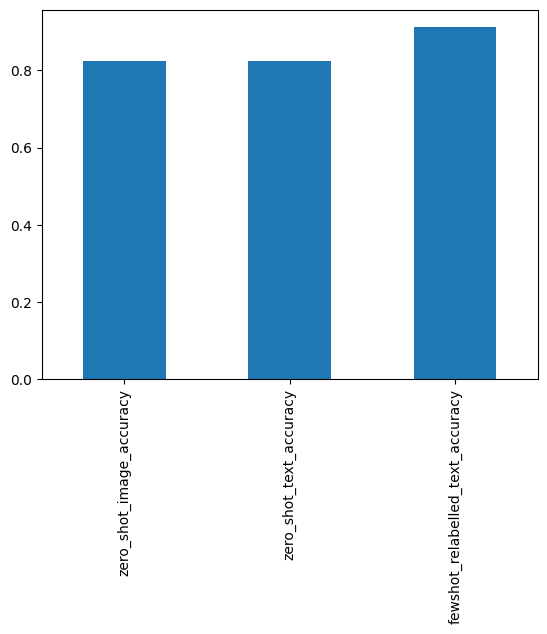

In [54]:
from pandas import Series

Series(
    dict(
        zero_shot_image_accuracy=zero_shot_image_accuracy,
        zero_shot_text_accuracy=zero_shot_text_accuracy,
        fewshot_relabelled_text_accuracy=fewshot_relabelled_text_accuracy,
    )
).plot.bar()